In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, pipeline
import torch
from torch.utils.data import Dataset
from tqdm import tqdm

In [10]:
# ========== 1. Load and Analyze Data ==========
def load_corpus(en_file, hi_file):
    with open(en_file, "r", encoding="utf-8") as f:
        en_lines = [line.strip() for line in f.readlines()]
    with open(hi_file, "r", encoding="utf-8") as f:
        hi_lines = [line.strip() for line in f.readlines()]
    assert len(en_lines) == len(hi_lines), f"Mismatch in {en_file} and {hi_file}: {len(en_lines)} vs {len(hi_lines)}"
    return pd.DataFrame({"english_text": en_lines, "hindi_text": hi_lines})

# File paths
train_df = load_corpus("IITB.en-hi.en", "IITB.en-hi.hi")
dev_df = load_corpus("dev.en", "dev.hi") 
test_df = load_corpus("test.en", "test.hi") 

# Basic analysis
print("Training set size:", len(train_df))
print("Dev set size:", len(dev_df))
print("Test set size:", len(test_df))
print("Sample training data:\n", train_df.head())
print("English sentence length stats:\n", train_df["english_text"].str.len().describe())
print("Hindi sentence length stats:\n", train_df["hindi_text"].str.len().describe())

# Remove empty or invalid rows
train_df = train_df.dropna().query("english_text != '' and hindi_text != ''")
dev_df = dev_df.dropna().query("english_text != '' and hindi_text != ''")
test_df = test_df.dropna().query("english_text != '' and hindi_text != ''")

Training set size: 1659083
Dev set size: 520
Test set size: 2507
Sample training data:
                                      english_text  \
0  Give your application an accessibility workout   
1               Accerciser Accessibility Explorer   
2  The default plugin layout for the bottom panel   
3     The default plugin layout for the top panel   
4  A list of plugins that are disabled by default   

                                          hindi_text  
0    अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें  
1                    एक्सेर्साइसर पहुंचनीयता अन्वेषक  
2              निचले पटल के लिए डिफोल्ट प्लग-इन खाका  
3               ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका  
4  उन प्लग-इनों की सूची जिन्हें डिफोल्ट रूप से नि...  
English sentence length stats:
 count    1.659083e+06
mean     7.481592e+01
std      8.645198e+01
min      0.000000e+00
25%      1.500000e+01
50%      4.800000e+01
75%      1.050000e+02
max      1.108800e+04
Name: english_text, dtype: float64
Hindi sentence lengt

In [17]:
# ========== 2. Assign Sentiment Labels ==========
# Use a pre-trained sentiment model to label English text
sentiment_classifier = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

def label_sentiment(texts):
    results = sentiment_classifier(texts, truncation=True, max_length=512)
    labels = []
    for res in results:
        if res["label"] == "POSITIVE":
            labels.append(0)  
        elif res["label"] == "NEGATIVE":
            labels.append(1)  
        else:
            labels.append(2)  # neutral (fallback)
    return labels

# Label training data 
train_texts = train_df["english_text"].tolist()[:5000]  
train_df = train_df.iloc[:len(train_texts)].copy()
train_df["sentiment_label"] = label_sentiment(train_texts)
print("Training label distribution:\n", train_df["sentiment_label"].value_counts())

# Label dev and test sets
dev_df["sentiment_label"] = label_sentiment(dev_df["english_text"].tolist())
test_df["sentiment_label"] = label_sentiment(test_df["english_text"].tolist())

# Define sentiment mapping
sentiment_mapping = {0: "positive", 1: "negative"}  # 3 classes for simplicity

Device set to use cpu


Training label distribution:
 sentiment_label
0    3195
1    1805
Name: count, dtype: int64


In [12]:
# ========== 3  Preprocess and Tokenize ==========
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

class SentimentDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts.tolist()
        self.labels = labels.tolist()

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = tokenizer(self.texts[idx], truncation=True, padding="max_length", max_length=128, return_tensors="pt")
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = SentimentDataset(train_df["english_text"], train_df["sentiment_label"])
dev_dataset = SentimentDataset(dev_df["english_text"], dev_df["sentiment_label"])
test_dataset = SentimentDataset(test_df["english_text"], test_df["sentiment_label"])

In [13]:
# ========== 4 Model Training ==========
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load model and move to GPU
try:
    model = AutoModelForSequenceClassification.from_pretrained(
        "xlm-roberta-base", 
        num_labels=3, 
        force_download=True,  
        cache_dir="./model_cache"  
    )
    model.to(device)  
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    raise

# Training arguments with GPU settings
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16, 
    num_train_epochs=3,
    learning_rate=2e-5,
    logging_dir="./logs",
    logging_steps=100,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    fp16=True, 
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
)

# Train the model
trainer.train()

Using device: cpu


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\HP\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Model loaded successfully!


Epoch,Training Loss,Validation Loss
1,0.321300,0.622031
2,0.173300,0.881265
3,0.098800,1.155189


TrainOutput(global_step=939, training_loss=0.26955475847815047, metrics={'train_runtime': 18234.8276, 'train_samples_per_second': 0.823, 'train_steps_per_second': 0.051, 'total_flos': 986675316480000.0, 'train_loss': 0.26955475847815047, 'epoch': 3.0})

In [18]:
# ========== 5 Evaluation ==========
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

print("Test set evaluation:")
print(classification_report(test_df["sentiment_label"], preds, target_names=sentiment_mapping.values()))

Test set evaluation:
              precision    recall  f1-score   support

    positive       0.58      0.81      0.67       921
    negative       0.85      0.66      0.74      1586

    accuracy                           0.71      2507
   macro avg       0.72      0.73      0.71      2507
weighted avg       0.75      0.71      0.72      2507



Confusion Matrix (Numerical):
          positive  negative
positive       743       178
negative       539      1047


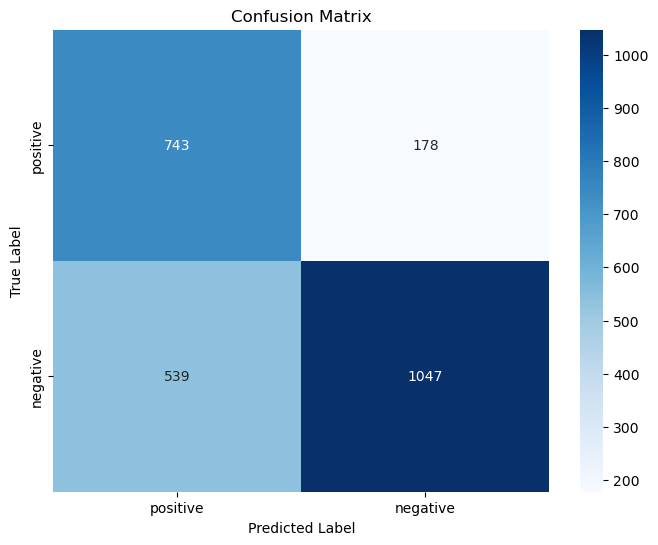

In [28]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


# Compute confusion matrix
cm = confusion_matrix(test_df["sentiment_label"], preds)
cm_df = pd.DataFrame(cm, index=sentiment_mapping.values(), columns=sentiment_mapping.values())

# Print numerical confusion matrix
print("Confusion Matrix (Numerical):")
print(cm_df)

# Plot confusion matrix with Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [30]:

# Calculate accuracy
accuracy = np.mean(preds == test_df["sentiment_label"])
accuracy_percentage = accuracy * 100

# Print accuracy
print(f"Accuracy: {accuracy:.4f} ({accuracy_percentage:.2f}%)")

Accuracy: 0.7140 (71.40%)


In [36]:
# ========== 6 Sentiment Preservation Check ==========
from transformers import pipeline
import numpy as np

# Use a Hindi sentiment classifier
hindi_classifier = pipeline("sentiment-analysis", model="cardiffnlp/twitter-xlm-roberta-base-sentiment")
hindi_preds = hindi_classifier(test_df["hindi_text"].tolist(), truncation=True, max_length=512)

# Map Hindi predictions to binary labels (0 = positive, 1 = negative)
hindi_labels = []
for pred in hindi_preds:
    label = pred["label"]
    score = pred["score"]
    if label == "Positive" and score > 0.6:  # Threshold for positive
        hindi_labels.append(0)
    else:
        hindi_labels.append(1)  # Default to negative (no neutral)

# Debug: Print distributions and sample predictions
print("English sentiment distribution:")
print(test_df["sentiment_label"].value_counts())
print("\nHindi sentiment distribution:")
print(pd.Series(hindi_labels).value_counts())
print("\nSample English vs Hindi predictions:")
for i in range(min(5, len(test_df))):
    print(f"English: {test_df['english_text'].iloc[i]} -> {test_df['sentiment_label'].iloc[i]}")
    print(f"Hindi: {test_df['hindi_text'].iloc[i]} -> {hindi_labels[i]} (raw: {hindi_preds[i]['label']}, score: {hindi_preds[i]['score']:.3f})")

# Calculate preservation accuracy
print("\nSentiment preservation accuracy (English vs Hindi):")
preservation_acc = np.mean(np.array(test_df["sentiment_label"]) == np.array(hindi_labels))
print(f"{preservation_acc:.4f}")

Device set to use cpu


English sentiment distribution:
sentiment_label
1    1586
0     921
Name: count, dtype: int64

Hindi sentiment distribution:
1    2507
Name: count, dtype: int64

Sample English vs Hindi predictions:
English: A black box in your car? -> 1
Hindi: आपकी कार में ब्लैक बॉक्स? -> 1 (raw: neutral, score: 0.812)
English: As America's road planners struggle to find the cash to mend a crumbling highway system, many are beginning to see a solution in a little black box that fits neatly by the dashboard of your car. -> 0
Hindi: जबकि अमेरिका के सड़क योजनाकार, ध्वस्त होते हुए हाईवे सिस्टम को सुधारने के लिए धन की कमी से जूझ रहे हैं, वहीं बहुत-से लोग इसका समाधान छोटे से ब्लैक बॉक्स में देख रहे हैं, जो आपकी कार के डैशबोर्ड पर सफ़ाई से फिट हो जाता है। -> 1 (raw: negative, score: 0.458)
English: The devices, which track every mile a motorist drives and transmit that information to bureaucrats, are at the center of a controversial attempt in Washington and state planning offices to overhaul the outdated sy